In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import json
import sys
sys.path.append('../Utils')

datapath='../Dataset/'
df_train=pd.read_csv(datapath+'train_data_for_modeling(no_standardization).csv')
print(f'Successfully loaded train data, the shape is {df_train.shape}')

with open(datapath+'all_final_features.json', 'r') as f:
    all_final_features=json.load(f)

feature_cols=[col for col in all_final_features if col not in ['RESALE_PRICE', 'LOG_RESALE_PRICE']]

X=df_train[feature_cols]
y=df_train['RESALE_PRICE']

X_train,X_valid,y_train,y_valid=train_test_split(X,y,test_size=0.2,random_state=42)
print('Successfully split the data')
print(f'The shape of train data is {X_train.shape},the shape of valid data is {X_valid.shape}')


Successfully loaded train data, the shape is (162570, 89)
Successfully split the data
The shape of train data is (130056, 87),the shape of valid data is (32514, 87)


In [43]:
# make the sale price log transformed
import numpy as np
y_train_log = y_train.apply(lambda x: np.log1p(x))
y_valid_log = y_valid.apply(lambda x: np.log1p(x))

In [44]:
!pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.4), 
        "n_estimators": trial.suggest_int('n_estimators', 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 100),
        # "gamma": trial.suggest_float("gamma", 0, 5),
    }
    model = xgb.XGBRegressor(**param, 
                            random_state=42,
                            n_jobs=-1,
                            tree_method = "hist",
                            device="cuda",
                            verbose=0,
                            eval_metric="rmse",
                            early_stopping_rounds=100,
                            )
    model.fit(
            X_train,
            y_train_log,
            eval_set=[(X_valid, y_valid_log)],
            verbose=False,
        )
    
    y_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid_log, y_pred)
    return score


In [ ]:
!pip install optuna
import optuna 

study = optuna.create_study(
    direction="minimize",
    study_name="hdb_resale_price_study"
)
study.optimize(objective, n_trials=200, show_progress_bar=True, verbose=0)

best_params = study.best_params
print(f"\nBest parameters: {best_params}")

[I 2025-11-05 23:45:32,998] A new study created in memory with name: hdb_resale_price_study


  0%|          | 0/200 [00:00<?, ?it/s]

/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:33] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:33] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:45:39,610] Trial 0 finished with value: 0.002748074264064651 and parameters: {'max_depth': 12, 'learning_rate': 0.10132058827264834, 'n_estimators': 208, 'subsample': 0.9266780806890447, 'colsample_bytree': 0.9613457618209889, 'min_child_weight': 22.796733183287618}. Best is trial 0 with value: 0.002748074264064651.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:39] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:39] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:45:59,789] Trial 1 finished with value: 0.0025369043411446702 and parameters: {'max_depth': 10, 'learning_rate': 0.027434479985576472, 'n_estimators': 832, 'subsample': 0.8128760987737951, 'colsample_bytree': 0.9285494612124987, 'min_child_weight': 50.67512242313087}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:59] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:59] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:45:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:46:14,579] Trial 2 finished with value: 0.0026957369459766423 and parameters: {'max_depth': 7, 'learning_rate': 0.02807666621087921, 'n_estimators': 897, 'subsample': 0.9555614321282058, 'colsample_bytree': 0.666168008443208, 'min_child_weight': 70.26551839918368}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:14] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:14] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:46:27,537] Trial 3 finished with value: 0.002727208465149876 and parameters: {'max_depth': 12, 'learning_rate': 0.12937365152815006, 'n_estimators': 446, 'subsample': 0.6274796863442554, 'colsample_bytree': 0.9458510214725167, 'min_child_weight': 53.29190713147863}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:27] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:27] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:46:37,946] Trial 4 finished with value: 0.0028283893144996934 and parameters: {'max_depth': 10, 'learning_rate': 0.21362061834047405, 'n_estimators': 614, 'subsample': 0.8835871116414076, 'colsample_bytree': 0.98003434385406, 'min_child_weight': 53.613389371969475}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:38] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:38] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:46:44,761] Trial 5 finished with value: 0.002869251870486877 and parameters: {'max_depth': 4, 'learning_rate': 0.19915702703569316, 'n_estimators': 738, 'subsample': 0.5235691672637038, 'colsample_bytree': 0.8156727763074638, 'min_child_weight': 96.69173927071185}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:44] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:44] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:46:51,008] Trial 6 finished with value: 0.0026785937758206026 and parameters: {'max_depth': 6, 'learning_rate': 0.19506128889263075, 'n_estimators': 576, 'subsample': 0.9197997969207203, 'colsample_bytree': 0.8375217128822092, 'min_child_weight': 16.9948610944857}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:51] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:51] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:46:56,093] Trial 7 finished with value: 0.0030868184815260207 and parameters: {'max_depth': 3, 'learning_rate': 0.2014653813666849, 'n_estimators': 771, 'subsample': 0.7557215714209319, 'colsample_bytree': 0.5787003425404098, 'min_child_weight': 31.99615889630347}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:56] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:56] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:46:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:47:05,961] Trial 8 finished with value: 0.002577870515430697 and parameters: {'max_depth': 12, 'learning_rate': 0.07136661731379491, 'n_estimators': 386, 'subsample': 0.6793470321919132, 'colsample_bytree': 0.526040204478293, 'min_child_weight': 39.04074381820411}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:06] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:06] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:47:14,223] Trial 9 finished with value: 0.0029848542050968617 and parameters: {'max_depth': 7, 'learning_rate': 0.26674901501309695, 'n_estimators': 788, 'subsample': 0.5098221186972107, 'colsample_bytree': 0.9316690151110423, 'min_child_weight': 78.51903427124277}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:14] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:14] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:47:19,608] Trial 10 finished with value: 0.0034168836370795175 and parameters: {'max_depth': 10, 'learning_rate': 0.3887702414715084, 'n_estimators': 968, 'subsample': 0.8079496091187381, 'colsample_bytree': 0.7379743095031132, 'min_child_weight': 4.93686662830293}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:19] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:19] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:47:32,702] Trial 11 finished with value: 0.002984939981690508 and parameters: {'max_depth': 10, 'learning_rate': 0.02602868339049856, 'n_estimators': 306, 'subsample': 0.6503784001737991, 'colsample_bytree': 0.5272675154056776, 'min_child_weight': 41.714197848520776}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:32] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:32] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:47:41,693] Trial 12 finished with value: 0.0026014970088148797 and parameters: {'max_depth': 9, 'learning_rate': 0.09347335376649366, 'n_estimators': 403, 'subsample': 0.669147667386009, 'colsample_bytree': 0.6427822988173584, 'min_child_weight': 61.83933338459625}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:41] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:41] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:47:49,132] Trial 13 finished with value: 0.005883757807783527 and parameters: {'max_depth': 12, 'learning_rate': 0.020940055309123073, 'n_estimators': 105, 'subsample': 0.8049052538261042, 'colsample_bytree': 0.8404641210646554, 'min_child_weight': 37.65959114812754}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:49] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:49] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:47:59,273] Trial 14 finished with value: 0.0025709450806477583 and parameters: {'max_depth': 9, 'learning_rate': 0.08331086897068712, 'n_estimators': 436, 'subsample': 0.7129769686853412, 'colsample_bytree': 0.7502530308987783, 'min_child_weight': 78.40056673263192}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:59] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:59] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:47:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:48:10,806] Trial 15 finished with value: 0.002564685921144433 and parameters: {'max_depth': 9, 'learning_rate': 0.11739062490468366, 'n_estimators': 659, 'subsample': 0.8394239687137912, 'colsample_bytree': 0.765854230058917, 'min_child_weight': 89.09575371053411}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:11] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:11] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:48:21,626] Trial 16 finished with value: 0.0026294032815504507 and parameters: {'max_depth': 8, 'learning_rate': 0.15522814667405707, 'n_estimators': 651, 'subsample': 0.8488046691756289, 'colsample_bytree': 0.8924905672629413, 'min_child_weight': 99.08942507900483}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:21] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:21] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:48:31,618] Trial 17 finished with value: 0.002712818718205246 and parameters: {'max_depth': 5, 'learning_rate': 0.2994384816473954, 'n_estimators': 879, 'subsample': 0.9978344115845089, 'colsample_bytree': 0.758660524493758, 'min_child_weight': 86.78777058043073}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:31] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:31] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:48:43,195] Trial 18 finished with value: 0.0026248231394690913 and parameters: {'max_depth': 8, 'learning_rate': 0.13998067575564888, 'n_estimators': 684, 'subsample': 0.7638451094871314, 'colsample_bytree': 0.889738764209777, 'min_child_weight': 63.89069397450345}. Best is trial 1 with value: 0.0025369043411446702.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:43] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:43] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:48:55,185] Trial 19 finished with value: 0.002510977911125561 and parameters: {'max_depth': 11, 'learning_rate': 0.06041828692175151, 'n_estimators': 538, 'subsample': 0.8403312837828651, 'colsample_bytree': 0.6836046513097168, 'min_child_weight': 88.8318929432579}. Best is trial 19 with value: 0.002510977911125561.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:55] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:55] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:48:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:49:22,072] Trial 20 finished with value: 0.0028281735914557683 and parameters: {'max_depth': 11, 'learning_rate': 0.014166383176639305, 'n_estimators': 478, 'subsample': 0.8723239148932634, 'colsample_bytree': 0.6835022697678113, 'min_child_weight': 1.615011871014218}. Best is trial 19 with value: 0.002510977911125561.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:22] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:22] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:49:32,336] Trial 21 finished with value: 0.0025445707781844252 and parameters: {'max_depth': 9, 'learning_rate': 0.05983303517566209, 'n_estimators': 529, 'subsample': 0.8185819033319124, 'colsample_bytree': 0.619981397359066, 'min_child_weight': 87.2742968620968}. Best is trial 19 with value: 0.002510977911125561.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:32] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:32] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:49:45,741] Trial 22 finished with value: 0.0025281273190826846 and parameters: {'max_depth': 11, 'learning_rate': 0.05736033813531126, 'n_estimators': 535, 'subsample': 0.8032831938118113, 'colsample_bytree': 0.6103197004193354, 'min_child_weight': 78.69854706906176}. Best is trial 19 with value: 0.002510977911125561.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:46] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:46] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:49:58,968] Trial 23 finished with value: 0.0025303000999860733 and parameters: {'max_depth': 11, 'learning_rate': 0.0610009022528164, 'n_estimators': 554, 'subsample': 0.7743908918569398, 'colsample_bytree': 0.5894289163432681, 'min_child_weight': 75.47270710558267}. Best is trial 19 with value: 0.002510977911125561.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:59] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:59] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:49:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:50:11,334] Trial 24 finished with value: 0.002509948578572225 and parameters: {'max_depth': 11, 'learning_rate': 0.05690347321985158, 'n_estimators': 535, 'subsample': 0.7304544829127131, 'colsample_bytree': 0.5841528957468051, 'min_child_weight': 76.39318284617845}. Best is trial 24 with value: 0.002509948578572225.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:11] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:11] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:50:23,466] Trial 25 finished with value: 0.0025275504894963267 and parameters: {'max_depth': 11, 'learning_rate': 0.05814245046255607, 'n_estimators': 503, 'subsample': 0.7154267129952381, 'colsample_bytree': 0.699956519916916, 'min_child_weight': 70.03500748243178}. Best is trial 24 with value: 0.002509948578572225.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:23] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:23] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:50:32,495] Trial 26 finished with value: 0.0027218933575273254 and parameters: {'max_depth': 11, 'learning_rate': 0.16878771470079817, 'n_estimators': 329, 'subsample': 0.7132403369608428, 'colsample_bytree': 0.7010608815344866, 'min_child_weight': 66.6168634600767}. Best is trial 24 with value: 0.002509948578572225.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:32] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:32] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:50:38,917] Trial 27 finished with value: 0.0030610332916454564 and parameters: {'max_depth': 11, 'learning_rate': 0.26173052911233036, 'n_estimators': 330, 'subsample': 0.5667039792568334, 'colsample_bytree': 0.5758045997529859, 'min_child_weight': 91.65600997207297}. Best is trial 24 with value: 0.002509948578572225.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:39] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:39] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:50:48,934] Trial 28 finished with value: 0.002585929463938749 and parameters: {'max_depth': 10, 'learning_rate': 0.10962067005517037, 'n_estimators': 478, 'subsample': 0.7302334908826101, 'colsample_bytree': 0.7079317120885957, 'min_child_weight': 58.87286768625612}. Best is trial 24 with value: 0.002509948578572225.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:49] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:49] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:50:56,381] Trial 29 finished with value: 0.0026408671811059504 and parameters: {'max_depth': 12, 'learning_rate': 0.0958975562244185, 'n_estimators': 291, 'subsample': 0.6219958121943315, 'colsample_bytree': 0.6608007770790414, 'min_child_weight': 70.72890624432955}. Best is trial 24 with value: 0.002509948578572225.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:56] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:56] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:50:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:51:12,030] Trial 30 finished with value: 0.0024978810740608217 and parameters: {'max_depth': 11, 'learning_rate': 0.05034041396338119, 'n_estimators': 704, 'subsample': 0.5847621590350638, 'colsample_bytree': 0.549023781928122, 'min_child_weight': 83.08852299163874}. Best is trial 30 with value: 0.0024978810740608217.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:12] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:12] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:51:28,514] Trial 31 finished with value: 0.00250694228452733 and parameters: {'max_depth': 11, 'learning_rate': 0.04600598240059566, 'n_estimators': 708, 'subsample': 0.5977468813621255, 'colsample_bytree': 0.5065515968385089, 'min_child_weight': 80.47868072899598}. Best is trial 30 with value: 0.0024978810740608217.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:28] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:28] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:51:45,927] Trial 32 finished with value: 0.002504535650211029 and parameters: {'max_depth': 12, 'learning_rate': 0.047532996925613594, 'n_estimators': 739, 'subsample': 0.5993525376380212, 'colsample_bytree': 0.5127572322425098, 'min_child_weight': 84.6281394111467}. Best is trial 30 with value: 0.0024978810740608217.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:46] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:46] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:51:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:52:03,463] Trial 33 finished with value: 0.0025107517347147195 and parameters: {'max_depth': 12, 'learning_rate': 0.04041238857261413, 'n_estimators': 692, 'subsample': 0.5640172038840348, 'colsample_bytree': 0.5051224642295448, 'min_child_weight': 83.7389732682347}. Best is trial 30 with value: 0.0024978810740608217.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:03] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:03] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:52:21,242] Trial 34 finished with value: 0.002495980333453957 and parameters: {'max_depth': 12, 'learning_rate': 0.044472200176262834, 'n_estimators': 725, 'subsample': 0.5849363972501462, 'colsample_bytree': 0.5528722473139454, 'min_child_weight': 94.26953869627681}. Best is trial 34 with value: 0.002495980333453957.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:21] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:21] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:52:42,503] Trial 35 finished with value: 0.002550931964740204 and parameters: {'max_depth': 12, 'learning_rate': 0.08626707725876298, 'n_estimators': 843, 'subsample': 0.5831015510096251, 'colsample_bytree': 0.5546802745090675, 'min_child_weight': 94.3556653132739}. Best is trial 34 with value: 0.002495980333453957.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:42] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:42] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:52:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:53:01,388] Trial 36 finished with value: 0.0024935891523582454 and parameters: {'max_depth': 12, 'learning_rate': 0.03823771021528044, 'n_estimators': 715, 'subsample': 0.6060930028045434, 'colsample_bytree': 0.5014011888590455, 'min_child_weight': 98.15871642072874}. Best is trial 36 with value: 0.0024935891523582454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:01] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:01] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:53:15,175] Trial 37 finished with value: 0.0026506306294032974 and parameters: {'max_depth': 12, 'learning_rate': 0.1256300791699625, 'n_estimators': 611, 'subsample': 0.5290102766992115, 'colsample_bytree': 0.551457415441441, 'min_child_weight': 98.64971094075459}. Best is trial 36 with value: 0.0024935891523582454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:15] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:15] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:53:37,382] Trial 38 finished with value: 0.002803391837904744 and parameters: {'max_depth': 12, 'learning_rate': 0.013138993761904659, 'n_estimators': 783, 'subsample': 0.5379952837454849, 'colsample_bytree': 0.5416680316651089, 'min_child_weight': 93.51556749749894}. Best is trial 36 with value: 0.0024935891523582454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:37] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:37] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:53:56,497] Trial 39 finished with value: 0.0024996207050415682 and parameters: {'max_depth': 10, 'learning_rate': 0.03136929848898762, 'n_estimators': 958, 'subsample': 0.6068382081793915, 'colsample_bytree': 0.6202750942574997, 'min_child_weight': 85.6857180560539}. Best is trial 36 with value: 0.0024935891523582454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:56] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:56] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:53:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:54:17,511] Trial 40 finished with value: 0.0024782094437367144 and parameters: {'max_depth': 10, 'learning_rate': 0.03523531972689561, 'n_estimators': 991, 'subsample': 0.6315108637383489, 'colsample_bytree': 0.6264994363257174, 'min_child_weight': 94.09962528994544}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:17] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:17] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:54:36,106] Trial 41 finished with value: 0.002495357634582795 and parameters: {'max_depth': 10, 'learning_rate': 0.032589445200741356, 'n_estimators': 988, 'subsample': 0.6280515664984859, 'colsample_bytree': 0.6130139995546491, 'min_child_weight': 99.02926603015487}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:36] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:36] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:54:55,602] Trial 42 finished with value: 0.0025009926675896746 and parameters: {'max_depth': 10, 'learning_rate': 0.07885533009951001, 'n_estimators': 994, 'subsample': 0.6429201595864912, 'colsample_bytree': 0.548901164963499, 'min_child_weight': 94.95492220843079}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:55] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:55] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:54:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:55:11,264] Trial 43 finished with value: 0.002550235754151874 and parameters: {'max_depth': 9, 'learning_rate': 0.032346886451178475, 'n_estimators': 907, 'subsample': 0.5510470202007813, 'colsample_bytree': 0.5995670695374153, 'min_child_weight': 98.40853607849712}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:11] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:11] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:55:16,345] Trial 44 finished with value: 0.0035729783624604858 and parameters: {'max_depth': 10, 'learning_rate': 0.3966768646518577, 'n_estimators': 829, 'subsample': 0.6783740249611807, 'colsample_bytree': 0.6395609113585995, 'min_child_weight': 92.17333356517557}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:16] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:16] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:55:31,579] Trial 45 finished with value: 0.002512291675760021 and parameters: {'max_depth': 8, 'learning_rate': 0.07376684001783514, 'n_estimators': 927, 'subsample': 0.5047796842927819, 'colsample_bytree': 0.5589671501129393, 'min_child_weight': 99.93605018870059}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:31] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:31] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:55:39,340] Trial 46 finished with value: 0.003351589035293318 and parameters: {'max_depth': 3, 'learning_rate': 0.1071747863911176, 'n_estimators': 840, 'subsample': 0.6341014855558698, 'colsample_bytree': 0.5271389134160684, 'min_child_weight': 47.34101107185826}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:39] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:39] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:55:50,200] Trial 47 finished with value: 0.004117281634008598 and parameters: {'max_depth': 7, 'learning_rate': 0.01081085299795263, 'n_estimators': 606, 'subsample': 0.66469293780371, 'colsample_bytree': 0.5753712792984291, 'min_child_weight': 82.69042361513318}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:50] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:50] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:55:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:56:00,711] Trial 48 finished with value: 0.0030299274937793585 and parameters: {'max_depth': 6, 'learning_rate': 0.3361700064346561, 'n_estimators': 751, 'subsample': 0.581241602152738, 'colsample_bytree': 0.6373011337599981, 'min_child_weight': 90.95271697601915}. Best is trial 40 with value: 0.0024782094437367144.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:00] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:00] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:56:20,862] Trial 49 finished with value: 0.0024689991114132848 and parameters: {'max_depth': 10, 'learning_rate': 0.0347010299909535, 'n_estimators': 870, 'subsample': 0.615159958911897, 'colsample_bytree': 0.5333908645744403, 'min_child_weight': 20.20498359997502}. Best is trial 49 with value: 0.0024689991114132848.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:21] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:21] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:56:31,224] Trial 50 finished with value: 0.0029050432089881045 and parameters: {'max_depth': 9, 'learning_rate': 0.21981644456454463, 'n_estimators': 952, 'subsample': 0.6172104221356153, 'colsample_bytree': 0.5290954290045099, 'min_child_weight': 17.974351726644798}. Best is trial 49 with value: 0.0024689991114132848.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:31] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:31] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:56:51,908] Trial 51 finished with value: 0.002464502010380047 and parameters: {'max_depth': 10, 'learning_rate': 0.03609671759761466, 'n_estimators': 873, 'subsample': 0.6495744535297322, 'colsample_bytree': 0.5674293982951264, 'min_child_weight': 27.526279752139082}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:52] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:52] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:56:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:57:14,261] Trial 52 finished with value: 0.0024680857466267787 and parameters: {'max_depth': 10, 'learning_rate': 0.031545686872851975, 'n_estimators': 865, 'subsample': 0.657718944116733, 'colsample_bytree': 0.5629140256221289, 'min_child_weight': 26.578817269807573}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:14] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:14] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:57:35,939] Trial 53 finished with value: 0.002480822834390633 and parameters: {'max_depth': 10, 'learning_rate': 0.02714124632533877, 'n_estimators': 876, 'subsample': 0.6891406584184728, 'colsample_bytree': 0.6001369930908497, 'min_child_weight': 26.552560737463047}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:36] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:36] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:57:55,303] Trial 54 finished with value: 0.0025082394918938913 and parameters: {'max_depth': 9, 'learning_rate': 0.024466488509552124, 'n_estimators': 879, 'subsample': 0.696814004028555, 'colsample_bytree': 0.5767317959594931, 'min_child_weight': 28.543672156798923}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:55] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:55] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:57:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:58:18,215] Trial 55 finished with value: 0.002488153227711581 and parameters: {'max_depth': 10, 'learning_rate': 0.02564786797380494, 'n_estimators': 819, 'subsample': 0.6641481867845955, 'colsample_bytree': 0.5022732368661135, 'min_child_weight': 9.384858058554478}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:18] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:18] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:58:38,721] Trial 56 finished with value: 0.002543853629930408 and parameters: {'max_depth': 10, 'learning_rate': 0.0720627151804771, 'n_estimators': 823, 'subsample': 0.6615110535333324, 'colsample_bytree': 0.5240817514673627, 'min_child_weight': 11.220393219792086}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:38] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:38] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:58:56,981] Trial 57 finished with value: 0.0030075990498449417 and parameters: {'max_depth': 8, 'learning_rate': 0.011226233752221551, 'n_estimators': 925, 'subsample': 0.6902187157296898, 'colsample_bytree': 0.5965230435865944, 'min_child_weight': 26.999550328094827}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:57] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:57] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:58:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:59:17,255] Trial 58 finished with value: 0.00250695076337419 and parameters: {'max_depth': 9, 'learning_rate': 0.024908675418594275, 'n_estimators': 870, 'subsample': 0.6608205556420829, 'colsample_bytree': 0.6629683991930138, 'min_child_weight': 20.40431403979533}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:17] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:17] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:59:31,059] Trial 59 finished with value: 0.0026330654982558172 and parameters: {'max_depth': 10, 'learning_rate': 0.09468622446736247, 'n_estimators': 792, 'subsample': 0.6501934348050923, 'colsample_bytree': 0.7976968521268796, 'min_child_weight': 10.169360644236106}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:31] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:31] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-05 23:59:51,391] Trial 60 finished with value: 0.0025500131780226832 and parameters: {'max_depth': 10, 'learning_rate': 0.07089469790855407, 'n_estimators': 912, 'subsample': 0.6936455249605815, 'colsample_bytree': 0.9904048795298253, 'min_child_weight': 35.48043177537245}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:51] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:51] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [23:59:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:00:07,784] Trial 61 finished with value: 0.002478009976785483 and parameters: {'max_depth': 9, 'learning_rate': 0.03418570202066283, 'n_estimators': 807, 'subsample': 0.6515508010675276, 'colsample_bytree': 0.5335252619687515, 'min_child_weight': 24.06635942515886}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:08] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:08] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:00:25,854] Trial 62 finished with value: 0.0025299985564444776 and parameters: {'max_depth': 9, 'learning_rate': 0.024620840630439483, 'n_estimators': 806, 'subsample': 0.6397059015806614, 'colsample_bytree': 0.5675625027561444, 'min_child_weight': 26.04738659464599}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:26] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:26] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:00:45,296] Trial 63 finished with value: 0.002482057392524049 and parameters: {'max_depth': 10, 'learning_rate': 0.06598152952856604, 'n_estimators': 858, 'subsample': 0.7352812237466515, 'colsample_bytree': 0.5318043174166978, 'min_child_weight': 31.82298194921771}. Best is trial 51 with value: 0.002464502010380047.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:45] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:45] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:00:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:01:02,954] Trial 64 finished with value: 0.0024479859339072677 and parameters: {'max_depth': 9, 'learning_rate': 0.042951642305004575, 'n_estimators': 868, 'subsample': 0.749960577118645, 'colsample_bytree': 0.5398897169749168, 'min_child_weight': 32.91712157376362}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:03] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:03] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:01:17,974] Trial 65 finished with value: 0.0025057018167686344 and parameters: {'max_depth': 8, 'learning_rate': 0.041750315672274316, 'n_estimators': 891, 'subsample': 0.7478016752546791, 'colsample_bytree': 0.5907997061865806, 'min_child_weight': 43.20998851972227}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:18] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:18] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:01:37,828] Trial 66 finished with value: 0.002518317481281079 and parameters: {'max_depth': 9, 'learning_rate': 0.08110384240432997, 'n_estimators': 950, 'subsample': 0.6809304225741462, 'colsample_bytree': 0.6284020023565527, 'min_child_weight': 15.371534725568308}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:38] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:38] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:01:54,308] Trial 67 finished with value: 0.0024530400660506615 and parameters: {'max_depth': 9, 'learning_rate': 0.053330023417814135, 'n_estimators': 766, 'subsample': 0.6983030348381556, 'colsample_bytree': 0.5653141064385987, 'min_child_weight': 23.919670652961486}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:54] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:54] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:01:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:02:08,558] Trial 68 finished with value: 0.0024698789894928084 and parameters: {'max_depth': 8, 'learning_rate': 0.052797336866934726, 'n_estimators': 776, 'subsample': 0.790489913569536, 'colsample_bytree': 0.5614140478392362, 'min_child_weight': 23.276170891192386}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:08] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:08] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:02:19,585] Trial 69 finished with value: 0.002574077188034262 and parameters: {'max_depth': 7, 'learning_rate': 0.1402511083786384, 'n_estimators': 762, 'subsample': 0.7753835578386673, 'colsample_bytree': 0.5385005742445214, 'min_child_weight': 21.536202351983647}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:19] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:19] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:02:32,522] Trial 70 finished with value: 0.0025109942129489995 and parameters: {'max_depth': 8, 'learning_rate': 0.05179069798621855, 'n_estimators': 667, 'subsample': 0.7698214049832797, 'colsample_bytree': 0.5700258550840088, 'min_child_weight': 31.795418717107154}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:32] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:32] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:02:45,859] Trial 71 finished with value: 0.002475675863960049 and parameters: {'max_depth': 8, 'learning_rate': 0.05333395647420491, 'n_estimators': 787, 'subsample': 0.7122668312385607, 'colsample_bytree': 0.513536907490121, 'min_child_weight': 23.90458996128458}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:46] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:46] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:02:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:03:00,450] Trial 72 finished with value: 0.0024718019375464624 and parameters: {'max_depth': 8, 'learning_rate': 0.06481430651326472, 'n_estimators': 795, 'subsample': 0.7066311037487177, 'colsample_bytree': 0.518416847249688, 'min_child_weight': 23.1320446049508}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:00] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:00] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:03:14,932] Trial 73 finished with value: 0.0024688134033496708 and parameters: {'max_depth': 8, 'learning_rate': 0.06095777806578524, 'n_estimators': 770, 'subsample': 0.7061723355562591, 'colsample_bytree': 0.5173848365886847, 'min_child_weight': 14.958494889598605}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:15] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:15] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:03:27,149] Trial 74 finished with value: 0.0025033828906903346 and parameters: {'max_depth': 7, 'learning_rate': 0.08666413683035334, 'n_estimators': 765, 'subsample': 0.7872766234327472, 'colsample_bytree': 0.5635776727828105, 'min_child_weight': 15.03917773686657}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:27] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:27] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:03:43,380] Trial 75 finished with value: 0.0024699594016718346 and parameters: {'max_depth': 8, 'learning_rate': 0.06420505186742517, 'n_estimators': 854, 'subsample': 0.7522519523269027, 'colsample_bytree': 0.5159071507087141, 'min_child_weight': 35.135498926223384}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:43] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:43] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:03:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:03:59,894] Trial 76 finished with value: 0.002521356855271193 and parameters: {'max_depth': 9, 'learning_rate': 0.10243176023362312, 'n_estimators': 850, 'subsample': 0.7449653998567953, 'colsample_bytree': 0.5411328208509975, 'min_child_weight': 34.85843440822168}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:00] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:00] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:04:11,293] Trial 77 finished with value: 0.002579804838907177 and parameters: {'max_depth': 6, 'learning_rate': 0.18719939215120926, 'n_estimators': 930, 'subsample': 0.7890648283367198, 'colsample_bytree': 0.5834157950237463, 'min_child_weight': 41.356232583757176}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:11] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:11] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:04:26,342] Trial 78 finished with value: 0.002519829166016568 and parameters: {'max_depth': 8, 'learning_rate': 0.11522928673450505, 'n_estimators': 899, 'subsample': 0.8166883103565605, 'colsample_bytree': 0.5182110731328521, 'min_child_weight': 30.527351310623466}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:26] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:26] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:04:39,543] Trial 79 finished with value: 0.0024764994365399804 and parameters: {'max_depth': 8, 'learning_rate': 0.04794049578007967, 'n_estimators': 732, 'subsample': 0.7271363506705307, 'colsample_bytree': 0.5607983636961729, 'min_child_weight': 19.369319383271606}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:39] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:39] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:04:46,493] Trial 80 finished with value: 0.0028538341113000546 and parameters: {'max_depth': 9, 'learning_rate': 0.22823208368736736, 'n_estimators': 856, 'subsample': 0.7572069121073272, 'colsample_bytree': 0.5479897563627605, 'min_child_weight': 12.805824333305267}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:46] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:46] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:04:49,663] Trial 81 finished with value: 0.003297235550304783 and parameters: {'max_depth': 8, 'learning_rate': 0.0659719417632521, 'n_estimators': 140, 'subsample': 0.703927535971884, 'colsample_bytree': 0.5188405228227574, 'min_child_weight': 34.456896532504274}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:49] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:49] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:04:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:04:59,821] Trial 82 finished with value: 0.002544498244977319 and parameters: {'max_depth': 7, 'learning_rate': 0.060758673451693106, 'n_estimators': 641, 'subsample': 0.7264448621540313, 'colsample_bytree': 0.5143959976467811, 'min_child_weight': 5.943382671260213}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:00] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:00] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:05:14,244] Trial 83 finished with value: 0.0024837874616031545 and parameters: {'max_depth': 8, 'learning_rate': 0.08848194851005861, 'n_estimators': 804, 'subsample': 0.7474417322696617, 'colsample_bytree': 0.5376175894944468, 'min_child_weight': 23.62048581092741}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:14] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:14] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:05:26,756] Trial 84 finished with value: 0.002627016502742349 and parameters: {'max_depth': 7, 'learning_rate': 0.04401991786947346, 'n_estimators': 752, 'subsample': 0.7918553804146636, 'colsample_bytree': 0.8866219629734884, 'min_child_weight': 29.37978535770635}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:27] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:27] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:05:47,052] Trial 85 finished with value: 0.0026167583351875963 and parameters: {'max_depth': 9, 'learning_rate': 0.018258545668330316, 'n_estimators': 861, 'subsample': 0.6786701070356422, 'colsample_bytree': 0.5633541053147466, 'min_child_weight': 38.02177224495665}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:47] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:47] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:05:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:06:00,555] Trial 86 finished with value: 0.002498139724299156 and parameters: {'max_depth': 8, 'learning_rate': 0.07319691012438151, 'n_estimators': 779, 'subsample': 0.7171414258621572, 'colsample_bytree': 0.7299822661930867, 'min_child_weight': 21.747147842342624}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:00] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:00] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:06:17,521] Trial 87 finished with value: 0.0024492493458060038 and parameters: {'max_depth': 9, 'learning_rate': 0.05671531805113141, 'n_estimators': 834, 'subsample': 0.7633420027255178, 'colsample_bytree': 0.5232642758038859, 'min_child_weight': 16.722342120146386}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:17] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:17] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:06:35,229] Trial 88 finished with value: 0.002462000500030805 and parameters: {'max_depth': 9, 'learning_rate': 0.05226247072309541, 'n_estimators': 895, 'subsample': 0.7613042990929522, 'colsample_bytree': 0.6105494566283621, 'min_child_weight': 16.927268163414553}. Best is trial 64 with value: 0.0024479859339072677.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:35] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:35] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:06:56,610] Trial 89 finished with value: 0.002444371706233769 and parameters: {'max_depth': 9, 'learning_rate': 0.03988163679574444, 'n_estimators': 969, 'subsample': 0.7636980689212111, 'colsample_bytree': 0.6015886757725746, 'min_child_weight': 18.30292080332643}. Best is trial 89 with value: 0.002444371706233769.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:56] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:56] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:06:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:07:15,875] Trial 90 finished with value: 0.0024588421489826345 and parameters: {'max_depth': 9, 'learning_rate': 0.038545743416257286, 'n_estimators': 938, 'subsample': 0.7630149006309053, 'colsample_bytree': 0.6470749079514626, 'min_child_weight': 17.145674958414048}. Best is trial 89 with value: 0.002444371706233769.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:16] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:16] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:07:35,552] Trial 91 finished with value: 0.002439636710891977 and parameters: {'max_depth': 9, 'learning_rate': 0.038451394341950114, 'n_estimators': 968, 'subsample': 0.7366373111033451, 'colsample_bytree': 0.6006923002144036, 'min_child_weight': 17.013832625548382}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:35] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:35] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:07:59,675] Trial 92 finished with value: 0.0024442078110627815 and parameters: {'max_depth': 9, 'learning_rate': 0.03934607414249161, 'n_estimators': 973, 'subsample': 0.766089461188146, 'colsample_bytree': 0.6085509517308964, 'min_child_weight': 16.669014705781976}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:59] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:59] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:07:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:08:20,737] Trial 93 finished with value: 0.002456258660251203 and parameters: {'max_depth': 9, 'learning_rate': 0.04182521118633316, 'n_estimators': 976, 'subsample': 0.7664319208661234, 'colsample_bytree': 0.6500627507889911, 'min_child_weight': 16.94866563556402}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:08:21] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:08:21] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:08:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:08:43,947] Trial 94 finished with value: 0.0025377795692148653 and parameters: {'max_depth': 9, 'learning_rate': 0.018145823919534287, 'n_estimators': 972, 'subsample': 0.8256500477628247, 'colsample_bytree': 0.6713981509876784, 'min_child_weight': 18.057079853814358}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:08:44] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:08:44] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:08:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:09:05,967] Trial 95 finished with value: 0.00244465783822105 and parameters: {'max_depth': 9, 'learning_rate': 0.04002342567993859, 'n_estimators': 974, 'subsample': 0.7626983341998231, 'colsample_bytree': 0.6072175189347855, 'min_child_weight': 7.0146592447097476}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:06] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:06] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:09:26,811] Trial 96 finished with value: 0.0024453831546360424 and parameters: {'max_depth': 9, 'learning_rate': 0.04285162619852621, 'n_estimators': 975, 'subsample': 0.7619217418291392, 'colsample_bytree': 0.6090216551266603, 'min_child_weight': 5.152074035097915}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:27] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:27] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:09:50,893] Trial 97 finished with value: 0.0024580235527851273 and parameters: {'max_depth': 9, 'learning_rate': 0.039882562027583425, 'n_estimators': 975, 'subsample': 0.7705084350791193, 'colsample_bytree': 0.6420472338287335, 'min_child_weight': 1.298019820798289}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:51] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:51] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:09:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:10:14,031] Trial 98 finished with value: 0.002525651870373857 and parameters: {'max_depth': 9, 'learning_rate': 0.018512385486483728, 'n_estimators': 975, 'subsample': 0.7776656969710715, 'colsample_bytree': 0.6451213030713319, 'min_child_weight': 7.032050661295743}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:14] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:14] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:10:37,727] Trial 99 finished with value: 0.0024613619983794954 and parameters: {'max_depth': 9, 'learning_rate': 0.04719909137630705, 'n_estimators': 994, 'subsample': 0.8051522745339098, 'colsample_bytree': 0.6293956581853836, 'min_child_weight': 2.724018928223059}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:38] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:38] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:10:43,294] Trial 100 finished with value: 0.0033561496614836726 and parameters: {'max_depth': 9, 'learning_rate': 0.3326815465418115, 'n_estimators': 965, 'subsample': 0.7349021133496817, 'colsample_bytree': 0.6053793878792006, 'min_child_weight': 3.5048442281204615}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:43] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:43] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:10:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:11:04,011] Trial 101 finished with value: 0.0024590396337011017 and parameters: {'max_depth': 9, 'learning_rate': 0.039589208499248706, 'n_estimators': 942, 'subsample': 0.766153236962784, 'colsample_bytree': 0.6867882808097738, 'min_child_weight': 7.363741526602862}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:04] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:04] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:11:23,039] Trial 102 finished with value: 0.002529912999936745 and parameters: {'max_depth': 9, 'learning_rate': 0.07850911457346527, 'n_estimators': 935, 'subsample': 0.7791025542761755, 'colsample_bytree': 0.6481334115069999, 'min_child_weight': 12.632864125700905}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:23] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:23] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:11:43,345] Trial 103 finished with value: 0.0024513452684312848 and parameters: {'max_depth': 9, 'learning_rate': 0.04023832074834603, 'n_estimators': 975, 'subsample': 0.7401673605747369, 'colsample_bytree': 0.6508831168277192, 'min_child_weight': 11.615185039233445}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:43] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:43] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:12:05,448] Trial 104 finished with value: 0.002446848389656856 and parameters: {'max_depth': 9, 'learning_rate': 0.04278553774104321, 'n_estimators': 976, 'subsample': 0.7436101120795913, 'colsample_bytree': 0.612085767684517, 'min_child_weight': 11.846405348360722}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:05] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:05] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:12:24,022] Trial 105 finished with value: 0.00246753045020977 and parameters: {'max_depth': 9, 'learning_rate': 0.0561837814549872, 'n_estimators': 915, 'subsample': 0.7397324192357124, 'colsample_bytree': 0.618994736901528, 'min_child_weight': 9.069918418942816}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:24] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:24] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:12:47,416] Trial 106 finished with value: 0.0024546317540269087 and parameters: {'max_depth': 9, 'learning_rate': 0.0290682239376892, 'n_estimators': 999, 'subsample': 0.7205296753267454, 'colsample_bytree': 0.5929254170007757, 'min_child_weight': 12.50626043359361}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:47] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:47] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:13:12,637] Trial 107 finished with value: 0.002446472160603556 and parameters: {'max_depth': 9, 'learning_rate': 0.028305360006651924, 'n_estimators': 995, 'subsample': 0.7250964301389645, 'colsample_bytree': 0.589610557329068, 'min_child_weight': 12.954808683459193}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:13:12] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:13:12] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:13:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:13:46,328] Trial 108 finished with value: 0.0026719441363025048 and parameters: {'max_depth': 10, 'learning_rate': 0.010311377801890603, 'n_estimators': 958, 'subsample': 0.9193490605040523, 'colsample_bytree': 0.6036982553997736, 'min_child_weight': 5.3278257352796405}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:13:46] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:13:46] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:14:07,286] Trial 109 finished with value: 0.0024853716603096924 and parameters: {'max_depth': 9, 'learning_rate': 0.02285896806855149, 'n_estimators': 913, 'subsample': 0.752940690965687, 'colsample_bytree': 0.5813513385063279, 'min_child_weight': 12.96046382580774}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:07] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:07] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:14:31,839] Trial 110 finished with value: 0.002526636835972245 and parameters: {'max_depth': 9, 'learning_rate': 0.01826566048800466, 'n_estimators': 949, 'subsample': 0.7969132661681778, 'colsample_bytree': 0.6162309036528067, 'min_child_weight': 7.819879089045196}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:32] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:32] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:14:53,458] Trial 111 finished with value: 0.002442640336181859 and parameters: {'max_depth': 9, 'learning_rate': 0.028627483896559593, 'n_estimators': 997, 'subsample': 0.7220576002190613, 'colsample_bytree': 0.5912890297848884, 'min_child_weight': 11.028075419140857}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:53] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:53] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:14:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:15:17,924] Trial 112 finished with value: 0.0024530705129701207 and parameters: {'max_depth': 9, 'learning_rate': 0.029778465684863878, 'n_estimators': 999, 'subsample': 0.742923518162818, 'colsample_bytree': 0.5887286518313931, 'min_child_weight': 11.578045392472776}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:15:18] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:15:18] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:15:40,049] Trial 113 finished with value: 0.0024605560044820363 and parameters: {'max_depth': 9, 'learning_rate': 0.04845482480025157, 'n_estimators': 979, 'subsample': 0.7330226824394873, 'colsample_bytree': 0.6333463905503387, 'min_child_weight': 13.976955107021336}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:15:40] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:15:40] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:15:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:16:04,159] Trial 114 finished with value: 0.0024962207417853874 and parameters: {'max_depth': 10, 'learning_rate': 0.0579092419622252, 'n_estimators': 959, 'subsample': 0.7206227930745706, 'colsample_bytree': 0.5976487187747169, 'min_child_weight': 19.297781416719}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:04] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:04] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:16:26,420] Trial 115 finished with value: 0.0024401758748500103 and parameters: {'max_depth': 9, 'learning_rate': 0.032497261177900263, 'n_estimators': 922, 'subsample': 0.7820964296811398, 'colsample_bytree': 0.5769250689391741, 'min_child_weight': 10.500409045769219}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:26] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:26] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:16:45,791] Trial 116 finished with value: 0.0024567006832931786 and parameters: {'max_depth': 9, 'learning_rate': 0.03202965012678598, 'n_estimators': 922, 'subsample': 0.7549729899644412, 'colsample_bytree': 0.6114995414127405, 'min_child_weight': 10.203250651043508}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:46] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:46] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:16:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:17:14,600] Trial 117 finished with value: 0.002474789666122658 and parameters: {'max_depth': 10, 'learning_rate': 0.022837545674530807, 'n_estimators': 944, 'subsample': 0.7838167698531742, 'colsample_bytree': 0.5782475624668115, 'min_child_weight': 4.26976325941501}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:14] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:14] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:17:33,191] Trial 118 finished with value: 0.002441402340876957 and parameters: {'max_depth': 9, 'learning_rate': 0.0429902267974445, 'n_estimators': 983, 'subsample': 0.7991271233892651, 'colsample_bytree': 0.620603555994309, 'min_child_weight': 11.223277126655143}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:33] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:33] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:17:49,335] Trial 119 finished with value: 0.002713375248050108 and parameters: {'max_depth': 8, 'learning_rate': 0.01635165118711425, 'n_estimators': 893, 'subsample': 0.8266308082486146, 'colsample_bytree': 0.6255001527025722, 'min_child_weight': 8.612959970176387}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:49] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:49] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:17:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:18:06,847] Trial 120 finished with value: 0.0024943108143419004 and parameters: {'max_depth': 9, 'learning_rate': 0.07133224851834816, 'n_estimators': 958, 'subsample': 0.853012981850819, 'colsample_bytree': 0.6048525690465546, 'min_child_weight': 14.982238852344564}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:07] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:07] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:18:25,693] Trial 121 finished with value: 0.0024423844366712522 and parameters: {'max_depth': 9, 'learning_rate': 0.04197816969715261, 'n_estimators': 988, 'subsample': 0.7989748411106412, 'colsample_bytree': 0.5878039994779576, 'min_child_weight': 10.638954250776944}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:25] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:25] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:18:46,335] Trial 122 finished with value: 0.0024612850647623523 and parameters: {'max_depth': 9, 'learning_rate': 0.04491554234337633, 'n_estimators': 998, 'subsample': 0.8043965581946585, 'colsample_bytree': 0.5862663034893353, 'min_child_weight': 5.682151926310219}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:46] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:46] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:18:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:19:02,566] Trial 123 finished with value: 0.00247162102210582 and parameters: {'max_depth': 9, 'learning_rate': 0.033613141692161674, 'n_estimators': 930, 'subsample': 0.8124787647527923, 'colsample_bytree': 0.5939067736835306, 'min_child_weight': 56.6538019404375}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:02] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:02] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:19:22,887] Trial 124 finished with value: 0.002463726839503975 and parameters: {'max_depth': 9, 'learning_rate': 0.027859406200441236, 'n_estimators': 982, 'subsample': 0.7945807216325057, 'colsample_bytree': 0.6213481980291304, 'min_child_weight': 10.214831019553449}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:23] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:23] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:19:52,067] Trial 125 finished with value: 0.002664775512716699 and parameters: {'max_depth': 10, 'learning_rate': 0.010308630520786087, 'n_estimators': 961, 'subsample': 0.777432448405866, 'colsample_bytree': 0.5735904995750788, 'min_child_weight': 7.425224509229309}. Best is trial 91 with value: 0.002439636710891977.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:52] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:52] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:20:09,423] Trial 126 finished with value: 0.0024340356761331314 and parameters: {'max_depth': 9, 'learning_rate': 0.04884120564437701, 'n_estimators': 911, 'subsample': 0.7580301537372093, 'colsample_bytree': 0.5519954498135343, 'min_child_weight': 14.349552923776347}. Best is trial 126 with value: 0.0024340356761331314.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:09] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:09] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:20:25,527] Trial 127 finished with value: 0.0024589232138027906 and parameters: {'max_depth': 8, 'learning_rate': 0.06694291334807978, 'n_estimators': 910, 'subsample': 0.7521224745219603, 'colsample_bytree': 0.5514638970775275, 'min_child_weight': 14.80854605536788}. Best is trial 126 with value: 0.0024340356761331314.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:25] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:25] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:20:50,701] Trial 128 finished with value: 0.0024452140839793025 and parameters: {'max_depth': 9, 'learning_rate': 0.04752179031229689, 'n_estimators': 942, 'subsample': 0.8326049279757624, 'colsample_bytree': 0.5834001522684853, 'min_child_weight': 2.459069639492908}. Best is trial 126 with value: 0.0024340356761331314.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:51] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:51] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:21:16,076] Trial 129 finished with value: 0.0025117802944273175 and parameters: {'max_depth': 10, 'learning_rate': 0.049180644758934196, 'n_estimators': 943, 'subsample': 0.8405455827743336, 'colsample_bytree': 0.610366139492807, 'min_child_weight': 4.126947573937537}. Best is trial 126 with value: 0.0024340356761331314.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:16] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:16] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:21:36,018] Trial 130 finished with value: 0.0024315715362298765 and parameters: {'max_depth': 9, 'learning_rate': 0.03645783370791861, 'n_estimators': 1000, 'subsample': 0.886072739669743, 'colsample_bytree': 0.5843622960244134, 'min_child_weight': 8.959968141455839}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:36] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:36] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:21:57,315] Trial 131 finished with value: 0.002439516442816328 and parameters: {'max_depth': 9, 'learning_rate': 0.03763419487818216, 'n_estimators': 985, 'subsample': 0.9348886304324174, 'colsample_bytree': 0.5840693058045564, 'min_child_weight': 1.4903908645559891}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:57] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:57] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:21:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:22:05,878] Trial 132 finished with value: 0.002879392320875497 and parameters: {'max_depth': 9, 'learning_rate': 0.24663130137270173, 'n_estimators': 998, 'subsample': 0.9673287994492353, 'colsample_bytree': 0.5836791169226254, 'min_child_weight': 1.389190742539117}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:06] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:06] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:22:26,983] Trial 133 finished with value: 0.0024586306006419206 and parameters: {'max_depth': 9, 'learning_rate': 0.030734355943075206, 'n_estimators': 960, 'subsample': 0.8934119725708305, 'colsample_bytree': 0.5976189172198118, 'min_child_weight': 6.1247302158534405}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:27] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:27] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:22:50,131] Trial 134 finished with value: 0.0024718124006197955 and parameters: {'max_depth': 9, 'learning_rate': 0.022507981196371794, 'n_estimators': 984, 'subsample': 0.8860621115593715, 'colsample_bytree': 0.5772765798685335, 'min_child_weight': 9.315952018205472}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:50] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:50] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:22:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:23:17,330] Trial 135 finished with value: 0.0024951889975697535 and parameters: {'max_depth': 10, 'learning_rate': 0.03266459169702612, 'n_estimators': 930, 'subsample': 0.9431599215884939, 'colsample_bytree': 0.5989957727667375, 'min_child_weight': 2.0576667637283563}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:17] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:17] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:23:26,907] Trial 136 finished with value: 0.003419471496501917 and parameters: {'max_depth': 4, 'learning_rate': 0.036827836713026335, 'n_estimators': 1000, 'subsample': 0.8324807385961552, 'colsample_bytree': 0.5891015637113228, 'min_child_weight': 3.6897673696454136}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:27] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:27] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:23:42,397] Trial 137 finished with value: 0.002435247984407468 and parameters: {'max_depth': 8, 'learning_rate': 0.04927655630338118, 'n_estimators': 950, 'subsample': 0.9093640476698036, 'colsample_bytree': 0.5747361935762072, 'min_child_weight': 8.359077599698535}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:42] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:42] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:23:58,042] Trial 138 finished with value: 0.002440898849523068 and parameters: {'max_depth': 8, 'learning_rate': 0.05889071449388024, 'n_estimators': 944, 'subsample': 0.905322847269473, 'colsample_bytree': 0.5722093228284852, 'min_child_weight': 7.553895551423901}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:58] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:58] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:23:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:24:12,285] Trial 139 finished with value: 0.002481561191450017 and parameters: {'max_depth': 8, 'learning_rate': 0.07707580050543879, 'n_estimators': 890, 'subsample': 0.9028250404658638, 'colsample_bytree': 0.5715877740510861, 'min_child_weight': 8.334947681705746}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:12] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:12] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:24:27,594] Trial 140 finished with value: 0.002440918942727714 and parameters: {'max_depth': 8, 'learning_rate': 0.05613904109391923, 'n_estimators': 920, 'subsample': 0.9203345366770153, 'colsample_bytree': 0.5722582757434362, 'min_child_weight': 9.86204738456563}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:27] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:27] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:24:42,247] Trial 141 finished with value: 0.0024441342292463035 and parameters: {'max_depth': 8, 'learning_rate': 0.06106024521197844, 'n_estimators': 947, 'subsample': 0.9284964919921431, 'colsample_bytree': 0.5561224873334407, 'min_child_weight': 10.358057537513586}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:42] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:42] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:24:57,608] Trial 142 finished with value: 0.002449246608659379 and parameters: {'max_depth': 8, 'learning_rate': 0.06223804249090201, 'n_estimators': 918, 'subsample': 0.9276477949454999, 'colsample_bytree': 0.5491280281984193, 'min_child_weight': 9.86346426122371}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:57] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:57] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:24:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:25:12,924] Trial 143 finished with value: 0.0024374400586447526 and parameters: {'max_depth': 8, 'learning_rate': 0.055036976847786065, 'n_estimators': 954, 'subsample': 0.913174500060312, 'colsample_bytree': 0.5563320759760481, 'min_child_weight': 10.715018420238057}. Best is trial 130 with value: 0.0024315715362298765.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:13] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:13] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:25:28,849] Trial 144 finished with value: 0.002431360275945255 and parameters: {'max_depth': 8, 'learning_rate': 0.06004181780792024, 'n_estimators': 956, 'subsample': 0.9187360050715453, 'colsample_bytree': 0.5568810947562376, 'min_child_weight': 15.993942696009006}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:29] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:29] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:25:45,170] Trial 145 finished with value: 0.0024439164067495862 and parameters: {'max_depth': 8, 'learning_rate': 0.0547906403781184, 'n_estimators': 907, 'subsample': 0.9200959611718064, 'colsample_bytree': 0.5562175259551722, 'min_child_weight': 10.91121869455609}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:45] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:45] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:25:59,446] Trial 146 finished with value: 0.002454557559410796 and parameters: {'max_depth': 8, 'learning_rate': 0.06867201902962447, 'n_estimators': 902, 'subsample': 0.9168788248074404, 'colsample_bytree': 0.5561683063290632, 'min_child_weight': 11.164187377395862}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:59] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:59] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:25:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:26:11,894] Trial 147 finished with value: 0.0024736010522433205 and parameters: {'max_depth': 7, 'learning_rate': 0.09239161623815542, 'n_estimators': 930, 'subsample': 0.9405191938929603, 'colsample_bytree': 0.5463319740621405, 'min_child_weight': 14.428287649231034}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:12] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:12] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:26:25,518] Trial 148 finished with value: 0.0024730379693509415 and parameters: {'max_depth': 8, 'learning_rate': 0.08218505367985766, 'n_estimators': 887, 'subsample': 0.8652365040528547, 'colsample_bytree': 0.5606551106672927, 'min_child_weight': 9.341924084740565}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:25] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:25] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:26:40,607] Trial 149 finished with value: 0.002447856303097283 and parameters: {'max_depth': 8, 'learning_rate': 0.05872153685561754, 'n_estimators': 948, 'subsample': 0.9654315844248226, 'colsample_bytree': 0.5672169057973238, 'min_child_weight': 13.527629383666193}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:40] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:40] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:26:55,456] Trial 150 finished with value: 0.0024427776684593006 and parameters: {'max_depth': 8, 'learning_rate': 0.05327290084163079, 'n_estimators': 909, 'subsample': 0.9107519277537047, 'colsample_bytree': 0.5552177607574412, 'min_child_weight': 10.932098545608266}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:55] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:55] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:26:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:27:10,597] Trial 151 finished with value: 0.0024421677919005498 and parameters: {'max_depth': 8, 'learning_rate': 0.05516781037064927, 'n_estimators': 906, 'subsample': 0.9110399343154356, 'colsample_bytree': 0.5530830083695567, 'min_child_weight': 11.108381343537932}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:10] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:10] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:27:26,207] Trial 152 finished with value: 0.002446022714513596 and parameters: {'max_depth': 8, 'learning_rate': 0.05529763435603883, 'n_estimators': 909, 'subsample': 0.9038327575953692, 'colsample_bytree': 0.5726574961211452, 'min_child_weight': 8.00212489063042}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:26] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:26] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:27:38,698] Trial 153 finished with value: 0.0024868573660451997 and parameters: {'max_depth': 7, 'learning_rate': 0.0527329545470517, 'n_estimators': 923, 'subsample': 0.8740586199703133, 'colsample_bytree': 0.5415654823597363, 'min_child_weight': 15.974715243807545}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:38] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:38] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:27:55,228] Trial 154 finished with value: 0.002456464968614967 and parameters: {'max_depth': 8, 'learning_rate': 0.07369549978327619, 'n_estimators': 886, 'subsample': 0.9059195909740265, 'colsample_bytree': 0.5319870192036148, 'min_child_weight': 5.5517379217195195}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:55] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:55] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:27:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:28:09,417] Trial 155 finished with value: 0.0024372449100777045 and parameters: {'max_depth': 8, 'learning_rate': 0.05283488694077937, 'n_estimators': 905, 'subsample': 0.9416700672706396, 'colsample_bytree': 0.5733242592537448, 'min_child_weight': 11.334970155429248}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:09] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:09] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:28:15,511] Trial 156 finished with value: 0.002698235549973632 and parameters: {'max_depth': 7, 'learning_rate': 0.06525720388188992, 'n_estimators': 385, 'subsample': 0.9425949164965044, 'colsample_bytree': 0.5723378214016789, 'min_child_weight': 7.144875673258616}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:15] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:15] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:28:31,015] Trial 157 finished with value: 0.002442768907555947 and parameters: {'max_depth': 8, 'learning_rate': 0.049555018312661, 'n_estimators': 956, 'subsample': 0.953405815794622, 'colsample_bytree': 0.5651813002374262, 'min_child_weight': 13.455567705389704}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:31] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:31] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:28:46,735] Trial 158 finished with value: 0.002522974955122057 and parameters: {'max_depth': 8, 'learning_rate': 0.04841707436659751, 'n_estimators': 957, 'subsample': 0.9758611138256617, 'colsample_bytree': 0.9648274000887355, 'min_child_weight': 14.632104199088062}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:47] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:47] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:28:55,732] Trial 159 finished with value: 0.0026466348721863892 and parameters: {'max_depth': 8, 'learning_rate': 0.1679714099158565, 'n_estimators': 932, 'subsample': 0.9375611895215051, 'colsample_bytree': 0.5765656587495666, 'min_child_weight': 13.013395788034908}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:55] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:55] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:28:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:29:10,098] Trial 160 finished with value: 0.0024570096747595365 and parameters: {'max_depth': 8, 'learning_rate': 0.06681729738222719, 'n_estimators': 959, 'subsample': 0.9543786771436303, 'colsample_bytree': 0.5659080399918842, 'min_child_weight': 20.87237295624985}. Best is trial 144 with value: 0.002431360275945255.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:10] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:10] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:29:25,767] Trial 161 finished with value: 0.0024295696975709454 and parameters: {'max_depth': 8, 'learning_rate': 0.04741987361892916, 'n_estimators': 941, 'subsample': 0.9101398072573903, 'colsample_bytree': 0.544967990400334, 'min_child_weight': 12.074789879900017}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:26] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:26] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:29:42,097] Trial 162 finished with value: 0.002475906576941287 and parameters: {'max_depth': 8, 'learning_rate': 0.04920018952835131, 'n_estimators': 981, 'subsample': 0.896043777529392, 'colsample_bytree': 0.7910669500037767, 'min_child_weight': 12.50192856014385}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:42] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:42] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:29:47,411] Trial 163 finished with value: 0.0031737876580346554 and parameters: {'max_depth': 8, 'learning_rate': 0.03486751697277358, 'n_estimators': 258, 'subsample': 0.9548192573750033, 'colsample_bytree': 0.5487867138389471, 'min_child_weight': 8.90183318079936}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:47] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:47] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:29:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:30:00,155] Trial 164 finished with value: 0.0024805160376267115 and parameters: {'max_depth': 7, 'learning_rate': 0.05934573836848639, 'n_estimators': 944, 'subsample': 0.9885383206542482, 'colsample_bytree': 0.5807500780250371, 'min_child_weight': 18.823900635263737}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:00] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:00] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:30:15,824] Trial 165 finished with value: 0.002430885649467806 and parameters: {'max_depth': 8, 'learning_rate': 0.047810412877034206, 'n_estimators': 959, 'subsample': 0.8851046458554135, 'colsample_bytree': 0.5389573213890149, 'min_child_weight': 14.006569935134525}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:16] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:16] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:30:23,870] Trial 166 finished with value: 0.002881781993274866 and parameters: {'max_depth': 8, 'learning_rate': 0.2843852312966688, 'n_estimators': 928, 'subsample': 0.8790526314143707, 'colsample_bytree': 0.5342070094796487, 'min_child_weight': 48.801684963555786}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:24] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:24] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:30:39,838] Trial 167 finished with value: 0.0024466651206173575 and parameters: {'max_depth': 8, 'learning_rate': 0.04298248289457904, 'n_estimators': 985, 'subsample': 0.886381138781255, 'colsample_bytree': 0.5457925291630422, 'min_child_weight': 16.34509334858922}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:40] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:40] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:30:54,856] Trial 168 finished with value: 0.0026727317618597847 and parameters: {'max_depth': 7, 'learning_rate': 0.02351437270377847, 'n_estimators': 972, 'subsample': 0.9319338400105301, 'colsample_bytree': 0.5302822706584542, 'min_child_weight': 5.261432981757505}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:55] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:55] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:30:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:31:10,695] Trial 169 finished with value: 0.0025038249991804146 and parameters: {'max_depth': 8, 'learning_rate': 0.07714619449354983, 'n_estimators': 940, 'subsample': 0.8959548553633834, 'colsample_bytree': 0.8652963987473419, 'min_child_weight': 7.5285975537780665}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:10] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:10] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:31:27,754] Trial 170 finished with value: 0.0024445228085833784 and parameters: {'max_depth': 8, 'learning_rate': 0.03629951004759969, 'n_estimators': 959, 'subsample': 0.9112588960799809, 'colsample_bytree': 0.5852429539746579, 'min_child_weight': 11.433479012209741}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:28] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:28] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:31:44,730] Trial 171 finished with value: 0.00243822675844708 and parameters: {'max_depth': 8, 'learning_rate': 0.04642204332398132, 'n_estimators': 960, 'subsample': 0.9215381353677882, 'colsample_bytree': 0.5634989458603695, 'min_child_weight': 13.329131349398779}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:45] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:45] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:31:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:32:01,156] Trial 172 finished with value: 0.0024417686704021565 and parameters: {'max_depth': 8, 'learning_rate': 0.0464674118688587, 'n_estimators': 984, 'subsample': 0.9223364625252444, 'colsample_bytree': 0.5708098397642904, 'min_child_weight': 15.295043203265758}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:01] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:01] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:32:17,463] Trial 173 finished with value: 0.0024548521528916455 and parameters: {'max_depth': 8, 'learning_rate': 0.05998349058311724, 'n_estimators': 920, 'subsample': 0.9238002000084043, 'colsample_bytree': 0.5599829410577952, 'min_child_weight': 14.83086225664616}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:17] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:17] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:32:25,248] Trial 174 finished with value: 0.0031973289246103554 and parameters: {'max_depth': 8, 'learning_rate': 0.367392536411668, 'n_estimators': 964, 'subsample': 0.8607414587326448, 'colsample_bytree': 0.5412447785147158, 'min_child_weight': 16.93012357944677}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:25] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:25] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:32:41,236] Trial 175 finished with value: 0.0024542924953382074 and parameters: {'max_depth': 8, 'learning_rate': 0.04229771309229577, 'n_estimators': 941, 'subsample': 0.9117063375104895, 'colsample_bytree': 0.5712521787216508, 'min_child_weight': 18.92301684444322}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:41] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:41] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:32:58,882] Trial 176 finished with value: 0.0024303253351190754 and parameters: {'max_depth': 8, 'learning_rate': 0.04823363962559833, 'n_estimators': 984, 'subsample': 0.9312427593798297, 'colsample_bytree': 0.553782297429879, 'min_child_weight': 13.517967952208597}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:59] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:59] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:32:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:33:13,213] Trial 177 finished with value: 0.002461557146431184 and parameters: {'max_depth': 8, 'learning_rate': 0.07107173959709202, 'n_estimators': 881, 'subsample': 0.927719543420762, 'colsample_bytree': 0.5513576998534697, 'min_child_weight': 14.46463672539834}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:13] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:13] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:33:23,552] Trial 178 finished with value: 0.002609683442167345 and parameters: {'max_depth': 7, 'learning_rate': 0.05197410353587196, 'n_estimators': 587, 'subsample': 0.8968567215406762, 'colsample_bytree': 0.540516208327673, 'min_child_weight': 13.077590887600739}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:23] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:23] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:33:42,049] Trial 179 finished with value: 0.0024376548428586735 and parameters: {'max_depth': 8, 'learning_rate': 0.06078662343887672, 'n_estimators': 971, 'subsample': 0.9343187668021338, 'colsample_bytree': 0.5627585715222143, 'min_child_weight': 15.59447494765129}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:42] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:42] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:33:57,467] Trial 180 finished with value: 0.002439075632684385 and parameters: {'max_depth': 8, 'learning_rate': 0.06662136410761851, 'n_estimators': 970, 'subsample': 0.9376633894775285, 'colsample_bytree': 0.5648313748787446, 'min_child_weight': 20.66741965097423}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:57] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:57] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:33:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:34:13,229] Trial 181 finished with value: 0.002443573229595164 and parameters: {'max_depth': 8, 'learning_rate': 0.06236592165960717, 'n_estimators': 978, 'subsample': 0.9461710118940541, 'colsample_bytree': 0.5690754465785358, 'min_child_weight': 16.482142826959}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:13] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:13] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:34:28,342] Trial 182 finished with value: 0.0024374132226168154 and parameters: {'max_depth': 8, 'learning_rate': 0.04754471993801615, 'n_estimators': 964, 'subsample': 0.933696206211131, 'colsample_bytree': 0.560396609289632, 'min_child_weight': 18.648000922403774}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:28] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:28] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:34:43,610] Trial 183 finished with value: 0.0024332582368327927 and parameters: {'max_depth': 8, 'learning_rate': 0.06363189061232863, 'n_estimators': 962, 'subsample': 0.9368785404324748, 'colsample_bytree': 0.5648016791455145, 'min_child_weight': 21.047565702743817}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:43] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:43] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:34:58,392] Trial 184 finished with value: 0.002469407497748139 and parameters: {'max_depth': 8, 'learning_rate': 0.08578258799194419, 'n_estimators': 954, 'subsample': 0.9365466789879037, 'colsample_bytree': 0.5588477997927433, 'min_child_weight': 19.14216468968013}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:58] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:58] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:34:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:35:12,760] Trial 185 finished with value: 0.0024556948047107863 and parameters: {'max_depth': 8, 'learning_rate': 0.06880740138676208, 'n_estimators': 937, 'subsample': 0.932593054453958, 'colsample_bytree': 0.5286579589757265, 'min_child_weight': 21.261683836279655}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:13] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:13] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:35:27,912] Trial 186 finished with value: 0.0024387150071181135 and parameters: {'max_depth': 8, 'learning_rate': 0.061888426026692166, 'n_estimators': 959, 'subsample': 0.9466578969709857, 'colsample_bytree': 0.5619883168364931, 'min_child_weight': 17.908288047604646}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:28] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:28] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:35:44,056] Trial 187 finished with value: 0.0024570618070523047 and parameters: {'max_depth': 8, 'learning_rate': 0.07797159773867735, 'n_estimators': 962, 'subsample': 0.9636902007138062, 'colsample_bytree': 0.5440234915072673, 'min_child_weight': 21.94713643234951}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:44] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:44] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:35:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:36:00,895] Trial 188 finished with value: 0.0024687222275770124 and parameters: {'max_depth': 7, 'learning_rate': 0.06436906515055818, 'n_estimators': 968, 'subsample': 0.9537439978902414, 'colsample_bytree': 0.560566296768501, 'min_child_weight': 25.10279364684648}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:01] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:01] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:36:16,795] Trial 189 finished with value: 0.002457513475161881 and parameters: {'max_depth': 8, 'learning_rate': 0.03606645375441275, 'n_estimators': 948, 'subsample': 0.9330644102746183, 'colsample_bytree': 0.5775329771976592, 'min_child_weight': 18.242223466235586}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:17] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:17] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:36:32,194] Trial 190 finished with value: 0.002433113595335722 and parameters: {'max_depth': 8, 'learning_rate': 0.05305647177233838, 'n_estimators': 998, 'subsample': 0.9464043391377445, 'colsample_bytree': 0.5493975065232356, 'min_child_weight': 19.524126223337618}. Best is trial 161 with value: 0.0024295696975709454.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:32] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:32] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:36:48,033] Trial 191 finished with value: 0.002428374571558907 and parameters: {'max_depth': 8, 'learning_rate': 0.052299448972104104, 'n_estimators': 1000, 'subsample': 0.946751335822619, 'colsample_bytree': 0.5510450353869524, 'min_child_weight': 20.00083936821995}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:48] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:48] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:36:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:37:03,354] Trial 192 finished with value: 0.002442143638914275 and parameters: {'max_depth': 8, 'learning_rate': 0.04864344898972628, 'n_estimators': 992, 'subsample': 0.9455395544245674, 'colsample_bytree': 0.5396419804958414, 'min_child_weight': 20.650752384107292}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:03] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:03] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:37:19,002] Trial 193 finished with value: 0.002431754675257905 and parameters: {'max_depth': 8, 'learning_rate': 0.05047205709062781, 'n_estimators': 996, 'subsample': 0.9472277944108244, 'colsample_bytree': 0.5507923088523523, 'min_child_weight': 19.7309676401183}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:19] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:19] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:37:37,659] Trial 194 finished with value: 0.0024353257294567484 and parameters: {'max_depth': 8, 'learning_rate': 0.06602088220595444, 'n_estimators': 998, 'subsample': 0.9727662866939972, 'colsample_bytree': 0.5245774171590101, 'min_child_weight': 20.25545852775967}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:37] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:37] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:37:53,866] Trial 195 finished with value: 0.002444411978823322 and parameters: {'max_depth': 8, 'learning_rate': 0.0695007306208759, 'n_estimators': 990, 'subsample': 0.9808432836300844, 'colsample_bytree': 0.5256714970246636, 'min_child_weight': 22.695852602647385}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:54] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:54] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:37:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:38:11,191] Trial 196 finished with value: 0.002435604374471203 and parameters: {'max_depth': 8, 'learning_rate': 0.06406374273110732, 'n_estimators': 1000, 'subsample': 0.9986935335753321, 'colsample_bytree': 0.5008557958272579, 'min_child_weight': 19.683114489215612}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:11] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:11] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:38:26,271] Trial 197 finished with value: 0.002451748050444638 and parameters: {'max_depth': 8, 'learning_rate': 0.08324575294706091, 'n_estimators': 997, 'subsample': 0.9890228053616007, 'colsample_bytree': 0.5131299775278652, 'min_child_weight': 19.17750454709132}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:26] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:26] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:38:40,482] Trial 198 finished with value: 0.0024801946690256095 and parameters: {'max_depth': 8, 'learning_rate': 0.0990405772388617, 'n_estimators': 973, 'subsample': 0.959199353118082, 'colsample_bytree': 0.5230754436186522, 'min_child_weight': 25.421893133110004}. Best is trial 191 with value: 0.002428374571558907.


/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:40] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:40] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  self.starting_round = model.num_boosted_rounds()
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/callback.py:386: UserWarning: [00:38:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "verbose" } are not used.

  self.starting_round = model.num_boosted_rounds()


[I 2025-11-06 00:38:55,311] Trial 199 finished with value: 0.0024495811112586413 and parameters: {'max_depth': 8, 'learning_rate': 0.07277065576447371, 'n_estimators': 995, 'subsample': 0.999028147469158, 'colsample_bytree': 0.5352780987438097, 'min_child_weight': 20.663711645911455}. Best is trial 191 with value: 0.002428374571558907.

Best parameters: {'max_depth': 8, 'learning_rate': 0.052299448972104104, 'n_estimators': 1000, 'subsample': 0.946751335822619, 'colsample_bytree': 0.5510450353869524, 'min_child_weight': 20.00083936821995}


In [55]:
sys.path.append('../Utils')
from ML_training_utils_tools import evaluate_model

best_model = xgb.XGBRegressor(**best_params, 
                            random_state=42,
                            n_jobs=-1,
                            tree_method = "hist",
                            device="cuda",
                            eval_metric="rmse",
                            )
best_model.fit(X_train, y_train_log, eval_set=[(X_valid, y_valid_log)], verbose=False)

y_pred_train_log = best_model.predict(X_train)
y_pred_valid_log = best_model.predict(X_valid)
y_pred_train = np.expm1(y_pred_train_log)
y_pred_valid = np.expm1(y_pred_valid_log)

train_rmse,train_mae,train_r2=evaluate_model(y_train,y_pred_train,'Train')
valid_rmse,valid_mae,valid_r2=evaluate_model(y_valid,y_pred_valid,'Valid')
print(f"Train RMSE: {train_rmse}, MAE: {train_mae}, R2: {train_r2}")
print(f"Valid RMSE: {valid_rmse}, MAE: {valid_mae}, R2: {valid_r2}")

/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [01:02:52] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/home/numbat/miniconda3/envs/cs5228/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [01:02:52] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)



Train Performance:
  RMSE: $19,246.15
  MAE:  $14,109.43
  R²:   0.9890

Valid Performance:
  RMSE: $26,213.24
  MAE:  $18,638.94
  R²:   0.9794
Train RMSE: 19246.15044393563, MAE: 14109.43166086628, R2: 0.9889943628077481
Valid RMSE: 26213.240967839592, MAE: 18638.938694485452, R2: 0.9793752327833997


/tmp/ipykernel_60955/3570082594.py:3: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_param_importances(study)
/tmp/ipykernel_60955/3570082594.py:4: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  vis.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

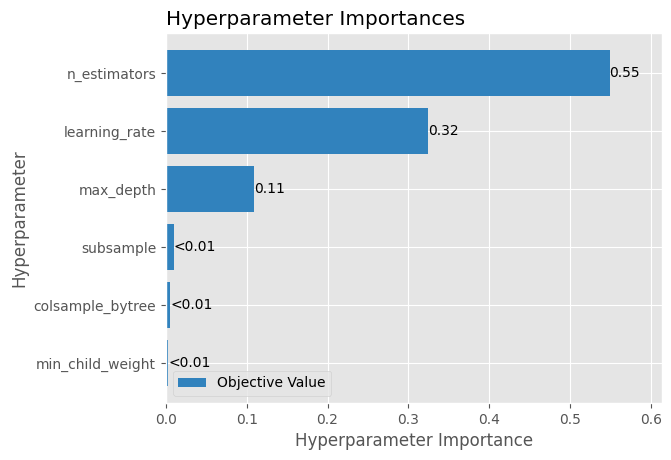

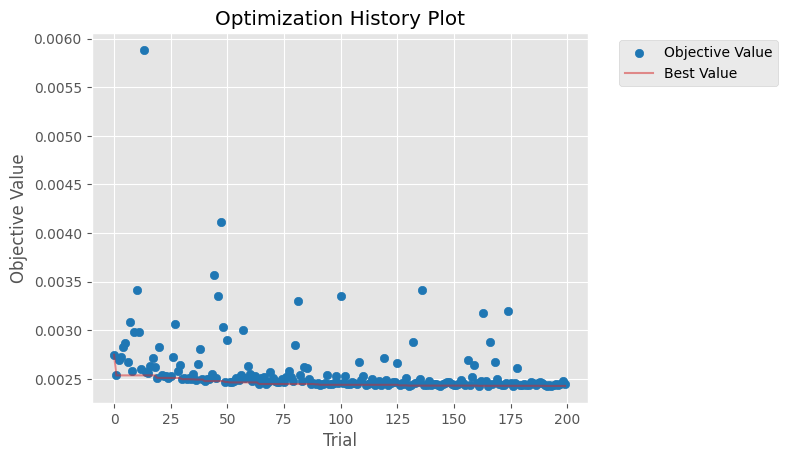

In [47]:
import optuna.visualization as vis

vis.matplotlib.plot_param_importances(study)
vis.matplotlib.plot_optimization_history(study)


In [ ]:
import pandas as pd, json, pathlib as pl
out = pl.Path('./results/')
out.mkdir(parents=True, exist_ok=True)

df_test = pd.read_csv(datapath+'test_data_for_modeling(no_standardization).csv')
X_test = df_test[feature_cols]
y_test_log = best_model.predict(X_test)
y_test = np.expm1(y_test_log)

# save y_test predictions
pd.DataFrame({'Predicted': y_test}).to_csv(out/'xgb_test_predictions.csv', index=True)
(out/'xgb_best_params.json').write_text(json.dumps(best_params, indent=2))

202